In [74]:
import random
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras import models
from tensorflow.keras import layers

BATCH_SIZE = 32
IMG_SIZE = 224

TRAIN_DIR = './data/pre/train_images/'
TEST_DIR = './data/pre/test_images/'
ROOT_DIR = './data/pre/'
MODELS_DIR = './Models'

TRAIN_DF = pd.read_csv('./data/pre/train.csv')
TEST_DF = pd.read_csv('./data/pre/test.csv')

CNTS = np.array([[1443, 362],
                 [295, 75],
                 [799, 200],
                 [154, 39],
                 [235, 60]])

In [120]:
def GetSingleClass(df,c,n):
    lx = (df['class'] == c) & (df['type'] == 0)
    res = list(df[lx]['filename'].to_numpy())
    if lx.sum() > n:
        return res[:n]
    m = n - lx.sum()
    lx = (df['class'] == c) & (df['type'] != 0)
    lst = list(df[lx].sort_values(by='type')['filename'].to_numpy())
    res += lst[:m]
    return res
    
def GetClassesElements(df,cv,nv):
    res = []
    for i in range(len(cv)):
        res += GetSingleClass(df,cv[i],nv[i])
    return res

def ModifyDataFrame(df,cv,nv):
    fv1 = GetClassesElements(df,cv[0],nv[0])
    fv2 = GetClassesElements(df,cv[1],nv[1])
    df = pd.DataFrame({'filename' : fv1 + fv2, 'class' : ['0']*len(fv1) + ['1']*len(fv2)})
    return df
        
def GetGenerator(df,rootdir,bs = 32):
    for i in range(100):
        df = df.sample(frac = 1).reset_index(drop=True)
    gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
    tr_gen = gen.flow_from_dataframe(df,target_size = (IMG_SIZE, IMG_SIZE),directory = rootdir,
                                     class_mode = 'binary', batch_size = bs) 
    return tr_gen

def SaveModel(model,name):
    path = os.path.join(MODELS_DIR,name)
    for suf in [''] + [str(i) for i in range(256)]:
        modified_path = path + suf
        if not os.path.exists(modified_path):
            os.makedirs(modified_path)
            path = modified_path
            break
    model.save(path)
    return path

def draw_evolution(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [121]:
train_set = [[1],[2,3,4]]
train_cnts = [[1188], [799,154,235]]
train_cnt = np.array([x for y in train_cnts for x in y]).sum()
train_df = ModifyDataFrame(TRAIN_DF,train_set,train_cnts)

test_set = [[1],[2,3,4]]
test_cnts = [[75], [25,25,25]]
test_cnt = np.array([x for y in test_cnts for x in y]).sum()
test_df = ModifyDataFrame(TEST_DF,test_set,test_cnts)

eval_set = [[1],[2,3,4]]
eval_cnts = [[75], [200,39,60]]
eval_cnt = np.array([x for y in test_cnts for x in y]).sum()

In [126]:
train_batch_size = 128
test_batch_size = 64
train_gen = GetGenerator(train_df,TRAIN_DIR,bs = train_batch_size)
test_gen = GetGenerator(test_df,TEST_DIR,bs = test_batch_size)
eval_gen = GetGenerator(test_df,TEST_DIR,bs = 64)

Found 2376 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


In [127]:
model = models.Sequential()
#model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

base_learning_rate = 0.0128 #0.0064
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 24, 24, 256)     

In [ ]:
start = time.time()
history = model.fit(train_gen,
                    steps_per_epoch = int(0 != train_cnt % train_batch_size) + train_cnt//train_batch_size,
                    epochs = 80,
                    validation_data = test_gen,
                    validation_steps = int(0 != test_cnt//test_batch_size) + test_cnt//test_batch_size)
elapsed_time = time.time() - start
print(elapsed_time)

Train for 19 steps, validate for 3 steps
Epoch 1/80
19/19 [==============================] - 227s 12s/step - loss: 9.6333 - accuracy: 0.4891 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 2/80
19/19 [==============================] - 197s 10s/step - loss: 0.6977 - accuracy: 0.5080 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/80
19/19 [==============================] - 209s 11s/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/80
19/19 [==============================] - 207s 11s/step - loss: 0.6933 - accuracy: 0.4903 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/80
19/19 [==============================] - 208s 11s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 6/80
19/19 [==============================] - 202s 11s/step - loss: 0.6935 - accuracy: 0.4924 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 7/80
19/19 [==============================] - 198s 10s/step - loss: 0.6934 - accuracy: 0.4996 - val_l

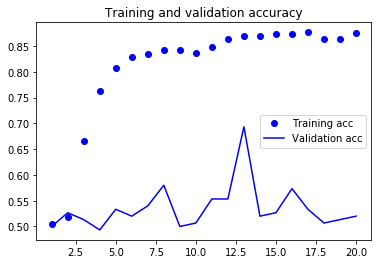

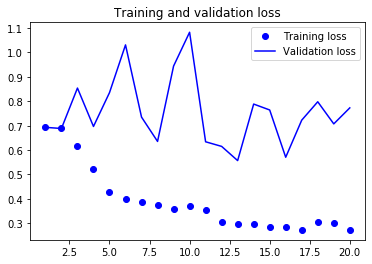

In [125]:
draw_evolution(history)

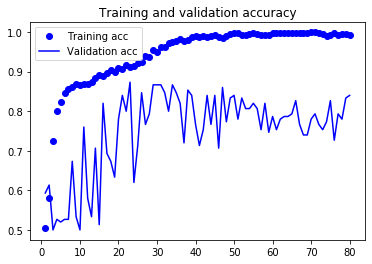

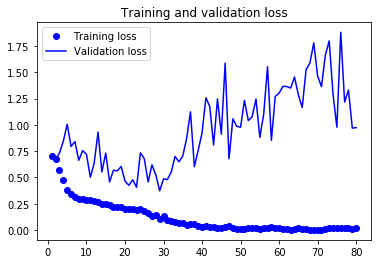

In [117]:
draw_evolution(history)

In [118]:
model.evaluate(eval_gen)

3/3 [==============================] - 8s 3s/step - loss: 0.7538 - accuracy: 0.8400


[0.7537725369135538, 0.84]

In [119]:
name_of_model = 'Model_5_dr05_512_0007_ep80_bch128_acc84'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_dr05_512_0007_ep80_bch128_acc84\assets


'./Models\\Model_5_dr05_512_0007_ep80_bch128_acc84'